In [54]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from pathlib import Path

## Audio MNIST Dataset

This dataset consists of numbers spoken.

> Goal:
> build a conv net to find the digit to the audio

## Example

Let's look at an example

In [4]:
waveform, sample_rate = torchaudio.load('/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings/0_yweweler_39.wav')

# Print information about the loaded audio
print(f"Shape of waveform: {waveform.shape}")
print(f"Sample rate: {sample_rate}")
print(f"Duration: {waveform.shape[1] / sample_rate:.2f} seconds")

Shape of waveform: torch.Size([1, 3540])
Sample rate: 8000
Duration: 0.44 seconds


In [41]:
def plot_audio(waveform):
    # 1. Plot the waveform (amplitude over time)
    plt.figure(figsize=(10, 4))
    time_axis = torch.arange(0, waveform.shape[1]) / sample_rate
    plt.plot(time_axis, waveform[0], color='blue')  # Plot first channel for stereo files
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.savefig('waveform_plot.png')
    plt.show()
    
    # 2. Create a spectrogram (frequency content over time)
    spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            win_length=1024,
            hop_length=512,
            n_mels=256
    )
    spec = spectrogram_transform(waveform)
    
    # Convert to decibels for better visualization
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(spec_db[0], aspect='auto', origin='lower', 
               extent=[0, waveform.shape[1]/sample_rate, 0, sample_rate/2])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig('spectrogram.png')
    plt.show()

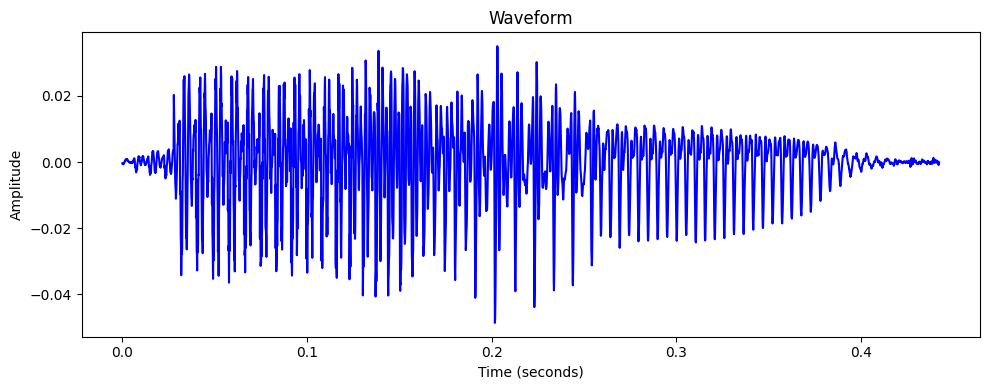

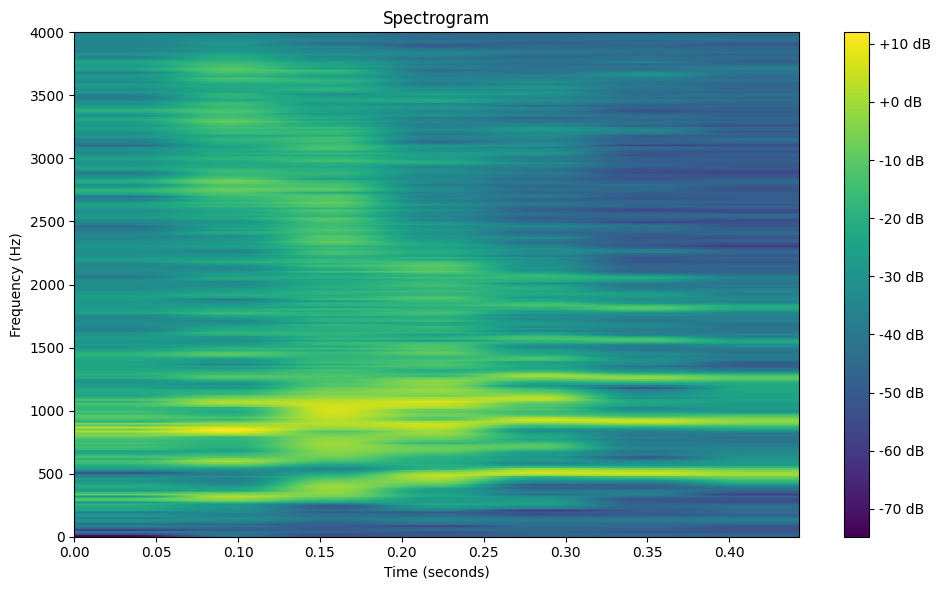

In [42]:
plot_audio(waveform)

## Dataloader

Let's build a Dataloader for getting all files

In [35]:

class SpokenDigitDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the wav files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
        
        # Get all wav files and their labels
        for file in sorted(os.listdir(root_dir)):
            if file.endswith('.wav'):
                # Parse filename to get label: {digitLabel}_{speakerName}_{index}.wav
                digit_label = int(file.split('_')[0])  # Extract the digit (0-9)
                
                self.file_paths.append(os.path.join(root_dir, file))
                self.labels.append(digit_label)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Load the audio file
        waveform, sample_rate = torchaudio.load(self.file_paths[idx])
        
        # Get label
        label = self.labels[idx]
        
        # Create sample dictionary
        sample = {'waveform': waveform, 'sample_rate': sample_rate, 'label': label}
        
        # Apply transforms if any
        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [24]:
# Example of transforms you might want to apply
class FixAudioLength:
    def __init__(self, max_length):
        self.max_length = max_length
        
    def __call__(self, sample):
        waveform = sample['waveform']
        current_length = waveform.shape[1]
        
        if current_length > self.max_length:
            # Truncate if longer than max_length
            sample['waveform'] = waveform[:, :self.max_length]
        elif current_length < self.max_length:
            # Pad with zeros if shorter
            padding = torch.zeros(waveform.shape[0], self.max_length - current_length)
            sample['waveform'] = torch.cat((waveform, padding), dim=1)
            
        return sample

In [52]:
# Additional transforms you might want to add
class MelSpectrogram:
    def __init__(self, sample_rate=16000, n_mels=64):
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            win_length=1024,
            hop_length=512,
            n_mels=n_mels
        )
        
    def __call__(self, sample):
        waveform = sample['waveform']
        sample['melspec'] = self.melspec(waveform)
        return sample

In [50]:
# Usage example
def get_dataloader(batch_size=32, num_workers=4):
    # Define the dataset path
    dataset_path = "/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings"
    
    # Define transforms
    # First, we'll analyze a few files to determine a good fixed length
    sample_rate = 8000  # Assuming 1-second clips at 8kHz, adjust as needed
    transform = Compose([
        FixAudioLength(max_length=sample_rate),
        MelSpectrogram(sample_rate=sample_rate, n_mels=256)
    ])
    
    # Create dataset
    dataset = SpokenDigitDataset(root_dir=dataset_path, transform=transform)
    
    # Create dataloader
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    return dataloader

## Probing the dataloader

We can check the dataloader now.
Let's use batches of size 32.

In [51]:
dataloader = get_dataloader(batch_size=32)
    
# Print dataset info
dataset = dataloader.dataset
print(f"Total samples: {len(dataset)}")
print(f"Distribution of labels: {torch.bincount(torch.tensor(dataset.labels))}")

# Get a batch
for batch in dataloader:
    mels = batch['melspec']
    labels = batch['label']
    print(f"Batch shape: {mels.shape}")
    print(f"Labels: {labels}")
    break  # Just show the first batch

Total samples: 3000
Distribution of labels: tensor([300, 300, 300, 300, 300, 300, 300, 300, 300, 300])
Batch shape: torch.Size([32, 1, 256, 63])
Labels: tensor([5, 9, 5, 7, 2, 0, 4, 8, 3, 1, 5, 9, 4, 2, 3, 3, 1, 8, 8, 3, 7, 6, 2, 0,
        7, 9, 7, 4, 6, 8, 0, 4])


We have 3000 samples.
One batch has the size torch.Size([32, 1, 8000]):

- First dimension (32): Your batch size
- Second dimension (1): Number of audio channels
- number of frequencies (265): Number of frequency steps
- 

## Net

Let's write a simple conv net for classifying the dataset:

In [53]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AudioCNN, self).__init__()
        # Input shape: [batch, 1, 256, 16]
        
        # First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        # Calculate size after convolutions and pooling
        # After 3 max-pooling operations with kernel size 2:
        # Height: 256 -> 128 -> 64 -> 32
        # Width: 16 -> 8 -> 4 -> 2
        self.fc1 = nn.Linear(128 * 32 * 2, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Apply first convolutional block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Apply second convolutional block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Apply third convolutional block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x




NameError: name 'nn' is not defined

In [ ]:
# Training function
def train(model, dataloader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in dataloader:
            mels = batch['melspec'].to(device)
            labels = batch['label'].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(mels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Print statistics
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Loss: {running_loss/len(dataloader):.4f}')
        print(f'Accuracy: {100 * correct / total:.2f}%')
    
    print('Finished Training')

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            mels = batch['melspec'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(mels)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

In [ ]:
# Example usage:
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create dataloader
    dataloader = get_dataloader(batch_size=32)
    
    # Create model
    model = AudioCNN(num_classes=10).to(device)  # 10 classes for digits 0-9
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train(model, dataloader, criterion, optimizer, device, epochs=10)
    
    # If you have a separate test set
    # test_dataloader = get_test_dataloader(batch_size=32)
    # evaluate(model, test_dataloader, device)
    
    # Save the model
    torch.save(model.state_dict(), "audio_cnn_model.pth")